# K Means Clustering


In [10]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
import random
import time

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#importing the dataset as a dataframe
df = pd.read_csv("taxis.csv").dropna()

## Pre-Processing


In [11]:
#Replacing credit card/cash in the target variable (payment) with 0/1
df['payment'] = df['payment'].map({'credit card':0, 'cash':1})

In [12]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['pickup'] = le.fit_transform(res_df['pickup'])
    res_df['dropoff'] = le.fit_transform(res_df['dropoff'])
    res_df['passengers'] = le.fit_transform(res_df['passengers'])
    res_df['distance'] = le.fit_transform(res_df['distance'])
    res_df['fare'] = le.fit_transform(res_df['fare'])
    res_df['tip'] = le.fit_transform(res_df['tip'])
    res_df['color'] = le.fit_transform(res_df['color'])
    res_df['tolls'] = le.fit_transform(res_df['tolls'])
    res_df['total'] = le.fit_transform(res_df['total'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df)

C:\Users\durga\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\durga\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[None, None, None, None]

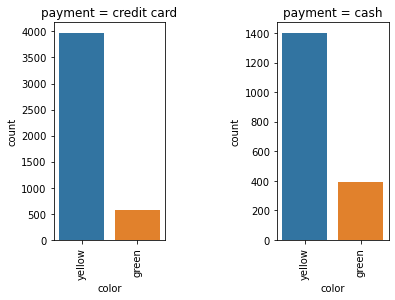

In [13]:
# Payment by total

df_payment_y = df[df['payment']==1]
df_payment_n = df[df['payment']==0]

fig, ax = plt.subplots(1,2)

fig.subplots_adjust(wspace=1)

sns.countplot(df_payment_n['color'], ax=ax[0])
ax[0].set_title('payment = credit card')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="center")

sns.countplot(df_payment_y['color'], ax=ax[1])
ax[1].set_title('payment = cash')
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="center")

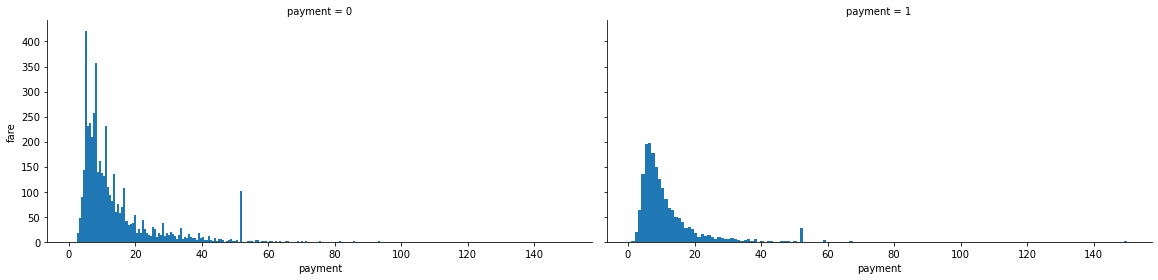

In [14]:


tenure = sns.FacetGrid(data=df, col='payment', height=4, aspect=2)
tenure.map(plt.hist, 'fare', bins=150)

tenure.set(xlabel='payment', ylabel='fare')
plt.show()

<AxesSubplot:xlabel='pickup_borough', ylabel='total'>

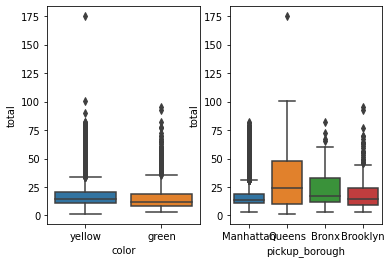

In [15]:
# Total Income levels by colour of the car and pickup place

fig, ax = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.2)


sns.boxplot(x='color', y='total', data=df, ax=ax[0])
sns.boxplot(x='pickup_borough', y='total', data=df, ax=ax[1])

The next step is to select which features we want to use with logistic regression and standardize them.

In [16]:
#Selecting features
X = encoded_df.drop(['payment','pickup_zone','dropoff_zone','pickup_borough','dropoff_borough'],axis =1)
y = encoded_df['payment']
y

0       0
1       1
2       0
3       0
4       0
       ..
6428    0
6429    0
6430    1
6431    0
6432    0
Name: payment, Length: 6342, dtype: int64

In [17]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


# K-Means Clustering 
Sor a given k, it selects k random points to be the initial centroids, then calculates the distance from each feature vector to each centroid and assigns each datapoint to a centroid. It then updates the clusters and recalculates the centroids, and updates the assignment of datapoints until it reaches maximum iterations.

In [18]:
class k_means_clustering():
    def __init__(self, k = 3, max_iter = 100, epsilon = 0.01) -> None:
        self.X = None
        self.k = k
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.centroid_history = None
        self.final_centroids = None

    def fit(self, X):
        self.X = X
        C_old = self.initialize_centroids()
        C_new = self.new_centroids(C_old)
        self.centroid_history = [C_old, C_new]
        centroid_distances = [self.distance(p[0], p[1]) for p in zip(C_old, C_new)]

        iter = 0
        while max(centroid_distances) > self.epsilon and iter<self.max_iter:
            C_old, C_new = C_new, self.new_centroids(C_new)
            self.centroid_history.append(C_new)
            centroid_distances = [self.distance(p[0], p[1]) for p in zip(C_old, C_new)]
            iter += 1
        self.final_centroids = C_new

    def initialize_centroids(self):
        centroids = []
        for _ in range(self.k):
            i = np.random.randint(len(self.X))
            centroids.append(self.X[i, :])
        return centroids

    def new_centroids(self, centroids):
        new_centroids = []
        A = self.make_classes(centroids)
        for i in range(len(centroids)):
            if len(A[i])>0:
                new_centroids.append(1/len(A[i])*sum(A[i])) 
        return new_centroids

    def distance(self, a, b):
        return np.sqrt((a-b)@(a-b))

    def clustering(self, x, centroids):
        distances = np.array([self.distance(x, centroid) for centroid in centroids])
        return np.argmin(distances)

    def make_classes(self, centroids):
        A = dict()
        for i in range(len(centroids)):
            A[i] = []
        for x in self.X:
            A[self.clustering(x, centroids)].append(x)
        return A

    def predict_classes(self, data, centroids):
        A = dict()
        for i in range(len(centroids)):
            A[i] = []
        for x in data:
            A[self.clustering(x, centroids)].append(x)
        return A
    
    def mse_classes(self, centroids):
        errors = []
        A_classes = self.make_classes(centroids)
        for i, centroid in enumerate(centroids):
            error = sum(.5*(centroid-a)@(centroid-a) for a in A_classes[i])
            errors.append(error)
        return sum(errors)

## Implementation
The cell below defines which variables we would like to use for clustering.

In [19]:
X = np.asarray(encoded_df[['distance','fare']])

The following cell runs k means with 2 clusters, reports the centroids and graphs the color-coded results in a scatterplot. 

[array([692.41847826, 100.41847826]), array([154.9757541 ,  15.21783123])]


Text(0, 0.5, 'FARE')

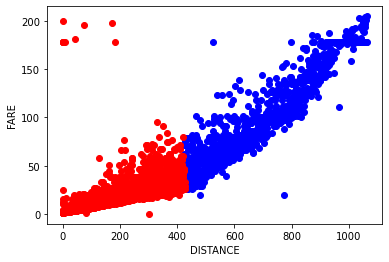

In [20]:
k_means = k_means_clustering(k=2, max_iter=100, epsilon=0.01)
k_means.fit(X)

centroids = k_means.final_centroids
print(centroids)

clusters = k_means.predict_classes(X, k_means.final_centroids)
for label, _ in clusters.items():
    for x in clusters[label]:
        if label == 0:
            plt.scatter(x[0],x[1],color = "blue")
        else:
            plt.scatter(x[0],x[1],color = "red")
plt.xlabel('DISTANCE')
plt.ylabel("FARE")

It appears this dataset does not have 2 clear clusters along these variables. The function below outputs the centroids and final MSE, as well as a graph of error over the course of the training process, for the number of clusters up to and including k to observe which value of k is the best fit for the dataset.

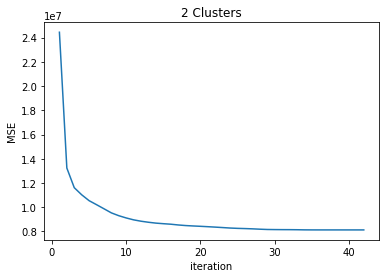

Centroids for 2 clusters: [array([386.17777778,  38.68024691]), array([86.50016863,  9.43777403]), array([913.01092896, 155.0273224 ]), array([207.44914756,  19.07054674]), array([639.766,  84.16 ])]
MSE for 2 clusters: 8128470.247


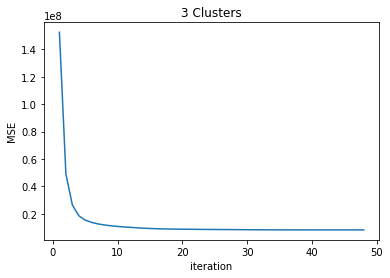

Centroids for 3 clusters: [array([639.766,  84.16 ]), array([913.01092896, 155.0273224 ]), array([207.44914756,  19.07054674]), array([86.50016863,  9.43777403]), array([386.17777778,  38.68024691])]
MSE for 3 clusters: 8128470.247


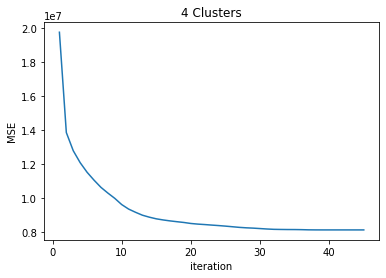

Centroids for 4 clusters: [array([639.766,  84.16 ]), array([207.44914756,  19.07054674]), array([386.17777778,  38.68024691]), array([913.01092896, 155.0273224 ]), array([86.50016863,  9.43777403])]
MSE for 4 clusters: 8128470.247


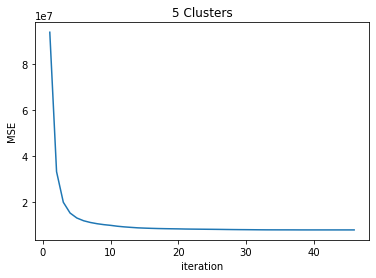

Centroids for 5 clusters: [array([86.50016863,  9.43777403]), array([913.01092896, 155.0273224 ]), array([386.17777778,  38.68024691]), array([207.44914756,  19.07054674]), array([639.766,  84.16 ])]
MSE for 5 clusters: 8128470.247


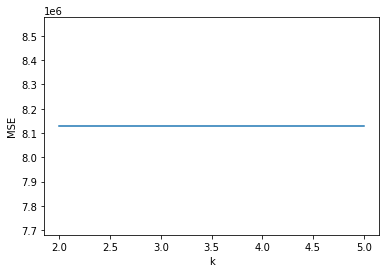

In [21]:
def k_means_compare(k, max_iter, epsilon):
    mse_list = []
    
    for j in range(1,k):
        k_means = k_means_clustering(k, max_iter, epsilon)
        k_means.fit(X)
        
        centroids = k_means.final_centroids
        mse = k_means.mse_classes(centroids)
        mse_list.append(mse)
        errors = [k_means.mse_classes(centroid) for centroid in k_means.centroid_history]
        
        #plot the MSE for a given k over a given number of iterations
        plt.figure()
        plt.plot([i for i in range(1,len(errors)+1)], errors)
        plt.title(f'{j+1} Clusters')
        plt.xlabel('iteration')
        plt.ylabel("MSE")
        plt.show()
        
        print("Centroids for", j + 1, "clusters:", centroids)
        print("MSE for", j + 1, "clusters:", round(mse, 3))

    #plot the MSE over the values of k to determine which k is best
    plt.figure()
    plt.plot([i for i in range(2,len(mse_list)+2)], mse_list)
    plt.xlabel('k')
    plt.ylabel("MSE")
    plt.show()
        
#calling the function                
k_means_compare(5, 100, 0.01)

# Using sklearn's functions
First we will create training and testing sets. Then we will use PCA to simplify the data.

In [22]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [23]:
# Make an instance of the model and specify that 90% of the variance needs to be retained
n = 90
pca = PCA(n/100)

# Fit the PCA on the training set
pca.fit(X_train)

print('To retain',n,'% of the variation, we needed',pca.n_components_,'components')

To retain 90 % of the variation, we needed 1 components


In [24]:
# Applying transformation to both Training and Test set

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [25]:
#create a list of the weighted cluster sum of squares
wcss = []
for i in range(1,11):
    #initiate the model
    k_means = KMeans(n_clusters=i,random_state=40)
    #fit the model with the data
    k_means.fit(X_train, y_train)
    wcss.append(k_means.inertia_)

Text(0, 0.5, 'weighted cluster sum of squares')

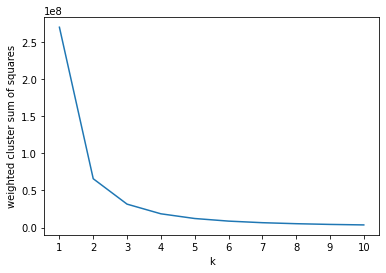

In [26]:
#Visualize the sum of squares for a variety of k values to assess which k is best
plt.plot(range(1,11),wcss)
plt.xticks(range(1,11));
plt.xlabel('k')
plt.ylabel('weighted cluster sum of squares')

In [27]:
#K-means without PCA

start = time.time()

#initiate the model
k_means = KMeans(n_clusters=4,random_state=40)
#fit the model with the data
k_means.fit(X_train, y_train)

end = time.time()
kmeans_time = end-start
print('Train Time (seconds) of K-Means Clustering without PCA:', kmeans_time)

y_pred_kmeans = k_means.predict(X_test)


Train Time (seconds) of K-Means Clustering without PCA: 0.12665748596191406


In [18]:
#K-means with PCA
start = time.time()

kmeans_pca = KMeans(n_clusters=4,random_state=40)
kmeans_pca.fit(X_train_pca,y_train)

end = time.time()
kmeans_time_pca = end-start
print('Train Time (seconds) of K-Means Clustering with PCA:', kmeans_time_pca)

y_pred_kmeans_pca = kmeans_pca.predict(X_test_pca)

Train Time (seconds) of K-Means Clustering with PCA: 0.061689138412475586
